PPMI Curation Script


In [1]:
# Imports
import json
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use("bmh")
plt.rcParams["figure.dpi"] = 150

In [ ]:
# Paths
metadata_path = Path("../metadata")
imaging_metadata_path = metadata_path / "PPMI_T1+fMRI_11_07_2025.csv"  
bids_path = metadata_path / "PPMI_BIDS_complete.csv"    
fmriprep_path = Path("../fmriprep") 

In [3]:
# Load filtered BIDS data
bids_complete_df = pd.read_csv(bids_path, dtype={"sub": str})
print(f"Total BIDS rows: {bids_complete_df.shape[0]}")
print(f"Unique subjects: {bids_complete_df['sub'].nunique()}")
print(f"Unique sessions: {bids_complete_df[['sub', 'ses']].drop_duplicates().shape[0]}")
print(f"BOLD scans: {(bids_complete_df['suffix'] == 'bold').sum()}")
print(f"T1w scans: {(bids_complete_df['suffix'] == 'T1w').sum()}\n")

Total BIDS rows: 2132
Unique subjects: 715
Unique sessions: 1066
BOLD scans: 1066
T1w scans: 1066



In [4]:
# Load and filter Imaging metadata
imaging_metadata_df = pd.read_csv(imaging_metadata_path, dtype={"Subject": str})
filtered_subs = bids_complete_df["sub"].unique()
imaging_filtered_df = imaging_metadata_df[imaging_metadata_df["Subject"].isin(filtered_subs)].reset_index(drop=True)
print(f"Imaging metadata rows: {imaging_filtered_df.shape[0]}")
print(f"Unique subjects: {imaging_filtered_df['Subject'].nunique()}\n")

Imaging metadata rows: 3350
Unique subjects: 715



In [10]:
# Keep only PD and Prodromal groups
imaging_group_df = imaging_filtered_df[imaging_filtered_df["Group"].isin(["PD", "Prodromal"])].reset_index(drop=True)
subject_group_counts = imaging_group_df.groupby("Group")["Subject"].nunique().reindex(["PD", "Prodromal"])
unique_sub_ses_filtered = imaging_group_df[["Subject", "Visit"]].drop_duplicates().shape[0]
print(f"After filtering to PD/Prodromal:")
print(f"Total rows: {imaging_group_df.shape[0]}")
print(f"Unique subjects: {imaging_group_df['Subject'].nunique()}")
print(f"PD: {subject_group_counts.get('PD', 0)}, Prodromal: {subject_group_counts.get('Prodromal', 0)}")
print(f"Unique sessions: {unique_sub_ses_filtered}\n")

After filtering to PD/Prodromal:
Total rows: 3221
Unique subjects: 672
PD: 256, Prodromal: 416
Unique sessions: 1103



In [6]:
# Check fMRIprep outputs
bids_bold_df = bids_complete_df.loc[bids_complete_df["suffix"] == "bold"].copy()

def check_fmriprep_outputs(path):
    cifti_path = fmriprep_path / path.replace("_bold.nii.gz", "_space-fsLR_den-91k_bold.dtseries.nii")
    mni_path = fmriprep_path / path.replace("_bold.nii.gz", "_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz")
    return pd.Series({'has_cifti': cifti_path.exists(), 'has_mni': mni_path.exists()})

tqdm.pandas(desc="Checking fMRIPrep outputs")
bids_bold_df[['has_cifti', 'has_mni']] = bids_bold_df['path'].progress_apply(check_fmriprep_outputs)
bids_bold_df["run_ok"] = bids_bold_df["has_cifti"] & bids_bold_df["has_mni"]

bids_pd_df = bids_bold_df[bids_bold_df["sub"].isin(imaging_group_df["Subject"])].copy()
complete_subs = bids_pd_df.loc[bids_pd_df["run_ok"], "sub"].unique()
print(f"{len(complete_subs)} subjects with complete fMRIPrep outputs")

imaging_final_df = imaging_group_df[imaging_group_df["Subject"].isin(complete_subs)].reset_index(drop=True)
print(f"Imaging metadata after filtering: {imaging_final_df.shape}\n")

Checking fMRIPrep outputs: 100%|██████████| 1066/1066 [07:09<00:00,  2.48it/s]

662 subjects with complete fMRIPrep outputs
Imaging metadata after filtering: (3176, 12)



In [7]:
# Match Imaging metadata with BIDS sessions
bids_include_df = bids_pd_df[bids_pd_df["run_ok"]].copy()
valid_sub_ses = bids_include_df[["sub", "ses"]].drop_duplicates()
imaging_final_df["ses"] = pd.to_datetime(imaging_final_df["Acq Date"]).dt.strftime("%Y%m%d").astype(int)

imaging_with_bids = imaging_final_df.merge(
    valid_sub_ses,
    left_on=["Subject", "ses"],
    right_on=["sub", "ses"],
    how="inner"
)
print(f"Matched scans: {len(imaging_with_bids)} rows")
print(f"Unique subjects: {imaging_with_bids['Subject'].nunique()}\n")

# Keep one row per subject (earliest session)
split_df = (
    imaging_with_bids
    .sort_values(["Subject", "ses"])
    .drop_duplicates(subset=["Subject"], keep="first")
    .loc[:, ["Subject", "Sex", "Age", "Group"]]
    .copy()
)

Matched scans: 3016 rows
Unique subjects: 662



In [ ]:
# Create Train/Val/Test splits
split_df["age_bin"], bins = pd.qcut(split_df["Age"], q=3, labels=["Q1", "Q2", "Q3"], retbins=True)
split_df["strat_key"] = (
    split_df["age_bin"].astype(str) + "_" +
    split_df["Sex"].astype(str) + "_" +
    split_df["Group"].astype(str)
)

train_df, temp_df = train_test_split(
    split_df, test_size=0.30, random_state=42, stratify=split_df["strat_key"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, stratify=temp_df["strat_key"]
)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}\n")

Train: 463, Val: 99, Test: 100



In [9]:
# Combine and finalize
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df["split"] = "train"
val_df["split"] = "validation"
test_df["split"] = "test"

combined_df_final = pd.concat([train_df, val_df, test_df], ignore_index=True)
combined_df_final = combined_df_final.sort_values(["split", "Subject"]).reset_index(drop=True)


In [11]:
# Summary statistics
print(f"\nPPMI Curation Summary")
print(f"Total subjects: {len(combined_df_final)}")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

print("\nAge ranges:")
for i in range(len(bins) - 1):
    print(f"  Q{i + 1}: {bins[i]:.0f}-{bins[i + 1]:.0f} years")

print("\nCounts by split:")
counts = combined_df_final.groupby("split").agg({
    "Group": lambda x: f"PD={sum(x=='PD')}, Prodromal={sum(x=='Prodromal')}",
    "Sex": lambda x: f"M={sum(x=='M')}, F={sum(x=='F')}",
    "Age": lambda x: f"{x.mean():.1f}±{x.std():.1f}"
})
counts.columns = ["Diagnosis", "Sex", "Age (mean±std)"]
print(counts)
print()


PPMI Curation Summary
Total subjects: 662
Train: 463 | Val: 99 | Test: 100

Age ranges:
  Q1: 35-63 years
  Q2: 63-70 years
  Q3: 70-87 years

Counts by split:
                        Diagnosis           Sex Age (mean±std)
split                                                         
test          PD=37, Prodromal=63    M=62, F=38       66.4±7.9
train       PD=178, Prodromal=285  M=282, F=181       66.0±8.2
validation    PD=39, Prodromal=60    M=60, F=39       66.9±7.4



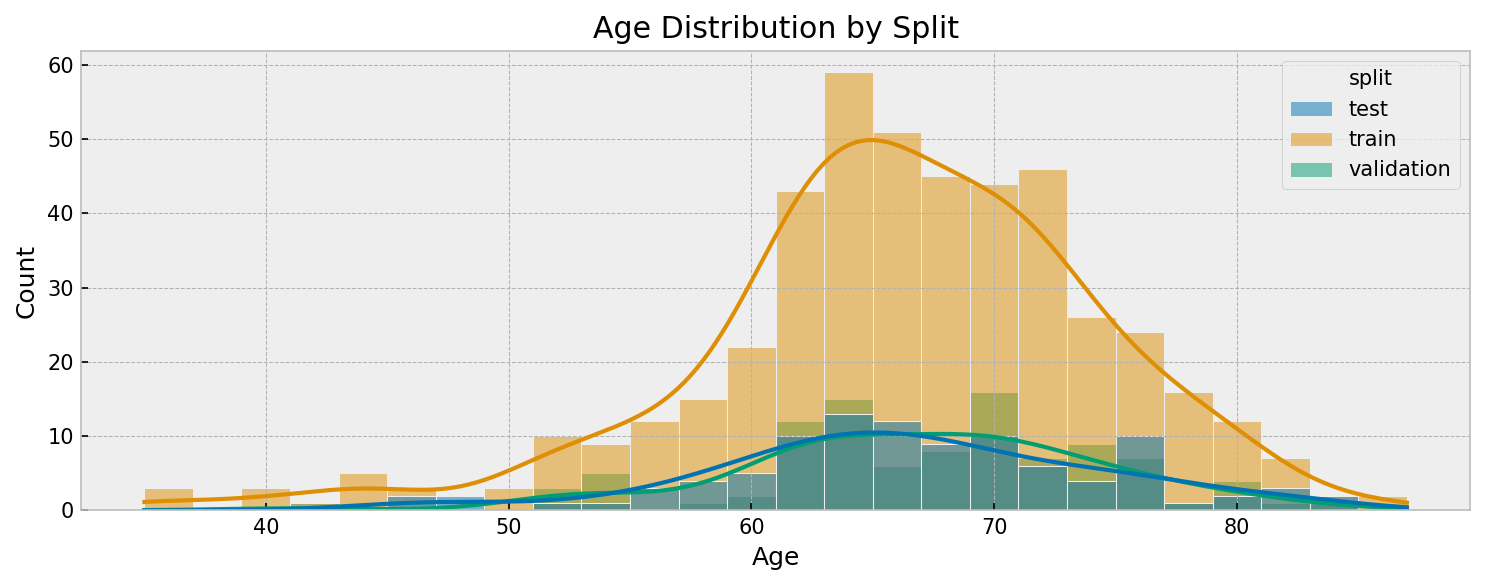

In [12]:
# Visualize age distribution
plt.figure(figsize=(10, 4))
sns.histplot(data=combined_df_final, x="Age", hue="split", kde=True, palette="colorblind")
plt.title("Age Distribution by Split")
plt.tight_layout()
plt.show()

In [13]:
# Save outputs
print("Saving outputs...")

# Save curated metadata
combined_df_final.to_csv(metadata_path / "PPMI_curated.csv", index=False)
print(f"Saved: {metadata_path / 'PPMI_curated.csv'}")

# Save list of included paths
include_subs_final = combined_df_final["Subject"].unique()
bids_final_paths = bids_include_df[bids_include_df["sub"].isin(include_subs_final)]["path"]
np.savetxt(metadata_path / "PPMI_curated_paths.txt", bids_final_paths, fmt="%s")
print(f"Saved: {metadata_path / 'PPMI_curated_paths.txt'}")

Saving outputs...
Saved: ../metadata/PPMI_curated.csv
Saved: ../metadata/PPMI_curated_paths.txt


In [14]:
# Save target maps
target_root = metadata_path / "targets"
target_root.mkdir(exist_ok=True)

for target_col, target_name in [("Group", "dx"), ("Sex", "sex"), ("age_bin", "age_bin")]:
    targets = {sub: label for sub, label in zip(combined_df_final["Subject"], combined_df_final[target_col])}
    targets = dict(sorted(targets.items()))
    with (target_root / f"ppmi_target_map_{target_name}.json").open("w") as f:
        json.dump(targets, f, indent=4)
    print(f"Saved: {target_root / f'ppmi_target_map_{target_name}.json'}")

print("\nCuration Complete!")
print(f"Final dataset: {len(combined_df_final)} subjects")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Saved: ../metadata/targets/ppmi_target_map_dx.json
Saved: ../metadata/targets/ppmi_target_map_sex.json
Saved: ../metadata/targets/ppmi_target_map_age_bin.json

Curation Complete!
Final dataset: 662 subjects
Train: 463 | Val: 99 | Test: 100
